# Demo 2: 表示可视化（Finetune 隐藏层 → t-SNE）

仿照 ProteinBERT demo：**去掉输出层，取 finetune 时分类头前的隐藏层**（即 `head-dropout` 输出的 128 维压缩表示），在 **训练集 / 验证集 / 测试集** 上分别做 t-SNE（共 3 张图）。
与 full experiment 一致：FinetuningModelGenerator + get_model_with_hidden_layers_as_outputs + two_layer head；若未保存权重则先 finetune 再保存。

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

PROJECT_ROOT = '/home/nemophila/projects/protein_bert'
BENCHMARKS_DIR = os.path.join(PROJECT_ROOT, 'anticrispr_benchmarks')
WORK_ROOT = os.path.join(PROJECT_ROOT, 'pssm_work')
FEAT_DIR = os.path.join(WORK_ROOT, 'features')
SEQ_LEN = 512
BATCH = 8
VALID_SEED = 42
os.makedirs(FEAT_DIR, exist_ok=True)

WEIGHTS_PATH = os.path.join(FEAT_DIR, 'bert_finetuned_anticrispr_seed42.keras')

def cache_path(split):
    return (
        os.path.join(FEAT_DIR, f'bert_finetuned_hidden_{split}.npy'),
        os.path.join(FEAT_DIR, f'bert_finetuned_hidden_labels_{split}.npy'),
    )

2026-02-20 20:19:43.434614: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
from proteinbert import (
    load_anticrispr_with_ids,
    load_pretrained_model,
    OutputType,
    OutputSpec,
    FinetuningModelGenerator,
    finetune,
)
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

train_df, test_df = load_anticrispr_with_ids(BENCHMARKS_DIR, benchmark_name='anticrispr_binary')
sub_train, sub_valid = train_test_split(
    train_df, test_size=0.1, stratify=train_df['label'], random_state=VALID_SEED
)
splits = {
    'train': (sub_train['seq'].tolist(), sub_train['label'].astype(int).to_numpy()),
    'valid': (sub_valid['seq'].tolist(), sub_valid['label'].astype(int).to_numpy()),
    'test':  (test_df['seq'].tolist(),  test_df['label'].astype(int).to_numpy()),
}
for name, (seqs, labels) in splits.items():
    print(f'{name}: n={len(seqs)}, Acr={labels.sum()}')

train: n=996, Acr=184
valid: n=111, Acr=21
test: n=286, Acr=26


## 加载或训练 Finetune 模型并提取隐藏层（head-dropout 输出）

In [3]:
output_type = OutputType(False, 'binary')
output_spec = OutputSpec(output_type, [0, 1])
pmg, enc = load_pretrained_model(
    local_model_dump_dir=os.path.join(PROJECT_ROOT, 'proteinbert_models'),
    download_model_dump_if_not_exists=True,
    validate_downloading=False,
)
mg = FinetuningModelGenerator(
    pmg,
    output_spec=output_spec,
    pretraining_model_manipulation_function=get_model_with_hidden_layers_as_outputs,
    dropout_rate=0.4,
    head_type='two_layer',
    loss_type='bce',
    lr=2e-5,
)

if os.path.exists(WEIGHTS_PATH):
    model = mg.create_model(SEQ_LEN)
    model.load_weights(WEIGHTS_PATH)
    print('Loaded finetuned weights from', WEIGHTS_PATH)
else:
    print('Finetuning (frozen then unfrozen)...')
    finetune(
        mg, enc, output_spec,
        sub_train['seq'], sub_train['label'],
        sub_valid['seq'], sub_valid['label'],
        seq_len=SEQ_LEN, batch_size=BATCH, max_epochs_per_stage=8,
        begin_with_frozen_pretrained_layers=True, n_final_epochs=0,
    )
    model = mg.create_model(SEQ_LEN)
    model.save_weights(WEIGHTS_PATH)
    print('Saved', WEIGHTS_PATH)

hidden_model = keras.Model(inputs=model.inputs, outputs=model.get_layer('head-dropout').output)

Finetuning (frozen then unfrozen)...
[2026_02_20-20:19:44] Training set: Filtered out 0 of 996 (0.0%) records of lengths exceeding 510.
[2026_02_20-20:19:44] Validation set: Filtered out 0 of 111 (0.0%) records of lengths exceeding 510.
[2026_02_20-20:19:44] Training with frozen pretrained layers...


2026-02-20 20:19:44.609920: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2026-02-20 20:19:44.611223: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2026-02-20 20:19:44.646135: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:2a:00.0 name: NVIDIA L40S computeCapability: 8.9
coreClock: 2.52GHz coreCount: 142 deviceMemorySize: 44.53GiB deviceMemoryBandwidth: 804.75GiB/s
2026-02-20 20:19:44.646298: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:ab:00.0 name: NVIDIA L40S computeCapability: 8.9
coreClock: 2.52GHz coreCount: 142 deviceMemorySize: 44.53GiB deviceMemoryBandwidth: 804.75GiB/s
2026-02-20 20:19:44.646319: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2026-02-20 20:19:44.6

Epoch 1/8


2026-02-20 20:19:52.872215: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2026-02-20 20:19:53.701437: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2026-02-20 20:19:53.712693: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2026-02-20 20:19:53.713603: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2026-02-20 20:19:56.063381: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2026-02-20 20:19:56.215201: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


125/125 [==============================] - 35s 160ms/step - loss: 0.7692 - val_loss: 0.3628
Epoch 2/8
125/125 [==============================] - 4s 28ms/step - loss: 0.4384 - val_loss: 0.3239
Epoch 3/8
125/125 [==============================] - 4s 28ms/step - loss: 0.4224 - val_loss: 0.2920
Epoch 4/8
125/125 [==============================] - 3s 28ms/step - loss: 0.3568 - val_loss: 0.2842
Epoch 5/8
125/125 [==============================] - 3s 28ms/step - loss: 0.3182 - val_loss: 0.2808
Epoch 6/8
125/125 [==============================] - 3s 28ms/step - loss: 0.3108 - val_loss: 0.2782
Epoch 7/8
125/125 [==============================] - 3s 28ms/step - loss: 0.2793 - val_loss: 0.2945
Epoch 8/8
125/125 [==============================] - 3s 26ms/step - loss: 0.2920 - val_loss: 0.2724
[2026_02_20-20:20:47] Training the entire fine-tuned model...
[2026_02_20-20:21:10] Incompatible number of optimizer weights - will not initialize them.
Epoch 1/8
125/125 [==============================] - 35

In [4]:
embeddings_by_split = {}
labels_by_split = {}
all_cached = all(
    os.path.exists(cache_path(s)[0]) and os.path.exists(cache_path(s)[1])
    for s in ('train', 'valid', 'test')
)

if all_cached:
    for s in ('train', 'valid', 'test'):
        ep, lp = cache_path(s)
        embeddings_by_split[s] = np.load(ep)
        labels_by_split[s] = np.load(lp)
        print(f'Loaded {s}:', embeddings_by_split[s].shape)
else:
    for s in ('train', 'valid', 'test'):
        seqs, labels = splits[s][0], splits[s][1]
        X = enc.encode_X(seqs, SEQ_LEN)
        emb = hidden_model.predict(X, batch_size=BATCH, verbose=0)
        embeddings_by_split[s] = emb
        labels_by_split[s] = labels
        ep, lp = cache_path(s)
        np.save(ep, emb)
        np.save(lp, labels)
        print(f'Saved {s}:', emb.shape)

Saved train: (996, 128)
Saved valid: (111, 128)
Saved test: (286, 128)


## t-SNE：训练集 / 验证集 / 测试集（各一张图）

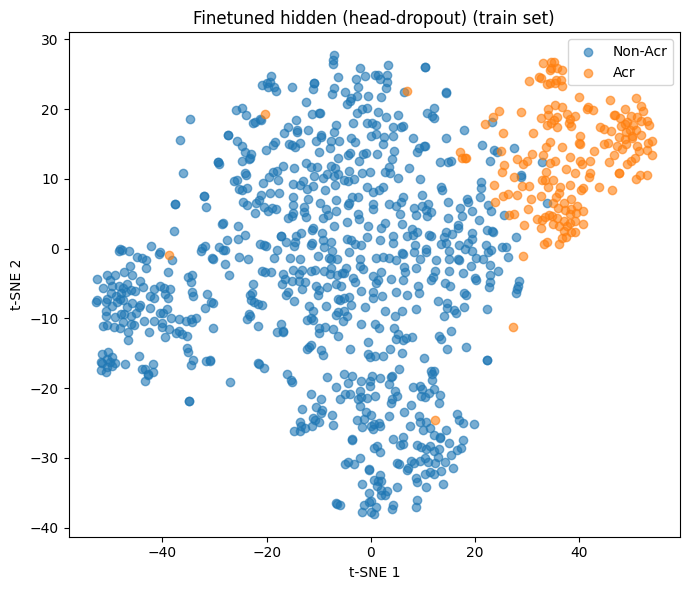

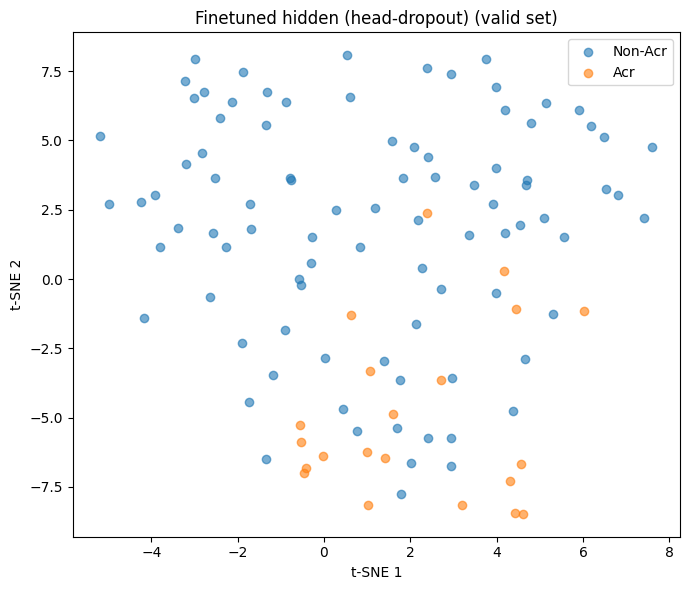

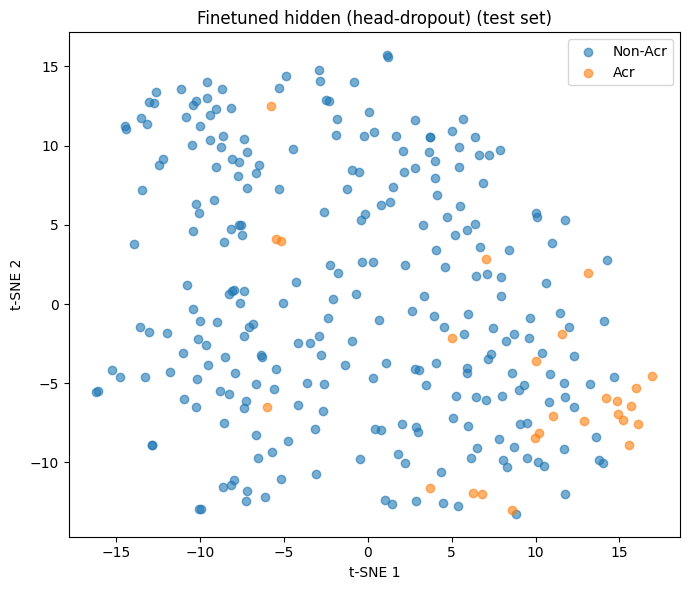

In [5]:
from sklearn.manifold import TSNE

for split_name in ('train', 'valid', 'test'):
    if split_name not in embeddings_by_split:
        ep, lp = cache_path(split_name)
        embeddings_by_split[split_name] = np.load(ep)
        labels_by_split[split_name] = np.load(lp)
    emb = embeddings_by_split[split_name]
    lab = labels_by_split[split_name]
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, max(5, len(emb)//4)))
    emb_2d = tsne.fit_transform(emb)
    fig, ax = plt.subplots(figsize=(7, 6))
    for l, name in [(0, 'Non-Acr'), (1, 'Acr')]:
        mask = lab == l
        ax.scatter(emb_2d[mask, 0], emb_2d[mask, 1], alpha=0.6, label=name)
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.legend()
    ax.set_title(f'Finetuned hidden (head-dropout) ({split_name} set)')
    plt.tight_layout()
    plt.show()